In [1]:
import numpy as np
import math

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

/tmp/ipykernel_139/2179033463.py:13: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


In [2]:
def shader():
    q_shader = QuantumCircuit(4)
    q_shader.cz(0,2)
    q_shader.cz(1,3)

    q_shader.x(1)
    q_shader.x(3)

    # We need to implement our own ccz gate.
    q_shader.h(3)
    q_shader.ccx(1,2,3)
    q_shader.h(3)

    q_shader.x(1)
    q_shader.x(3)
    
    q_shader = q_shader.to_gate()
    q_shader.name = "Shader Circuit"
    
    return q_shader


def shader_counter():
    q_shader = QuantumCircuit(5)
    # Since we need ccz gates, we have to use H + CCX + H:
    q_shader.h(4)
    
    q_shader.ccx(0,2,4)
    q_shader.ccx(1,3,4)

    q_shader.x(1)
    q_shader.x(3)

    # We need to implement our own ccz gate.
    q_shader.mcx([1,2,3],4)

    q_shader.x(1)
    q_shader.x(3)
    
    q_shader.h(4)
    
    q_shader = q_shader.to_gate()
    q_shader.name = "Shader"
    
    return q_shader


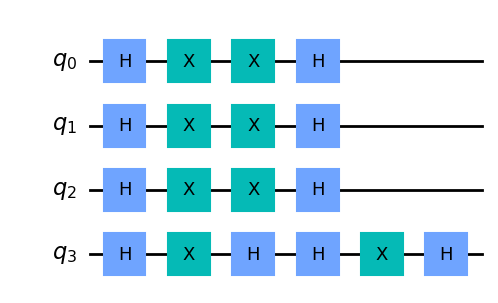

In [3]:
def grover():
    q_grover = QuantumCircuit(4)
    for i in range(4):
        q_grover.h(i)
    for i in range(4):
        q_grover.x(i)   
        
    # We need a 3 controlled Z gate.
    q_grover.h(3)
    q_grover.mcx([0,1,2],3)
    q_grover.h(3)
    
    for i in range(4):
        q_grover.x(i)
    for i in range(4):
        q_grover.h(i)  
        
    q_grover = q_grover.to_gate()
    q_grover.name = "Grover's Diffuser"
    
    return q_grover


def grover_counter():
    q_grover = QuantumCircuit(5)
    for i in range(4):
        q_grover.h(i)
    for i in range(4):
        q_grover.x(i)   
        
    # We need a 3 controlled Z gate.
    q_grover.h(3)
    q_grover.mcx([0,1,2,3],4)
    q_grover.h(3)
    
    for i in range(4):
        q_grover.x(i)
    for i in range(4):
        q_grover.h(i)  
        
    q_grover = q_grover.to_gate()
    q_grover.name = "Grover's Diffuser"
    
    return q_grover

q_test = QuantumCircuit(4)
for i in range(4):
    q_test.h(i)
for i in range(4):
    q_test.x(i)   
        
# We need a 3 controlled Z gate.
q_test.h(3)
q_test.h(3)
    
for i in range(4):
    q_test.x(i)
for i in range(4):
    q_test.h(i)  
    
q_test.draw()
        

In [4]:
def get_rightmost_one(gray_code_term, n):
    for i in range( (n-1), -1, -1):
        if(gray_code_term[i] == '1'):
            return i
    
    return 0


def get_second_rightmost_one(gray_code_term, rightmost_term, n):
    for i in range( (rightmost_term - 1), -1, -1):
        if(gray_code_term[i] == '1'):
            return i
        
    return 0

def reverse_string(string):
    #print("String: ", string)
    string = list(string)
    string.reverse()
    #print("String Reverse:" , string)
    #print("Return value: ", ''.join(string))
    return ''.join(string)

def modify_gray(gray_init, n):
    gray_final = []
    zero_element = ''
    for i in range(n):
        zero_element = zero_element + '0'
    
    gray_init.remove(zero_element)
    
    for i in gray_init:
        gray_final.append(reverse_string(i))
    
    return(gray_final)

def generate_gray(n):
    if( n == 1 ):
        return ['0','1']
    
    gray_n_minus_one = generate_gray( (n-1) )
    gray_n_minus_one_reverse = generate_gray( (n-1) )
    gray_n_minus_one_reverse.reverse()
    
    gray_n_minus_one = ['0' + x for x in gray_n_minus_one]
    gray_n_minus_one_reverse = ['1' + x for x in gray_n_minus_one_reverse]
    
    return gray_n_minus_one + gray_n_minus_one_reverse

def get_gray_diff(first, second, n):
    diff_index = 0
    for i in range(n):
        if(first[i] != second[i]):
            diff_index = i
            break
    
    return diff_index

def qncz(n):
    qncz = QuantumCircuit( (n + 1) )
    
    theta = np.pi / (2**(n - 1))
    
    gray_code_temp = generate_gray(n)
    gray_code = modify_gray(gray_code_temp, n)
    
    for i in range( len(gray_code) ):
        if (i == 0):
            current_index = 0
            qncz.cp(theta, 0, n)
            theta = -theta
            continue
        
        #print("Current Iteration: ", i, "Gray Code: ", gray_code[i])
    
        changing_index = get_gray_diff(gray_code[ (i - 1) ], gray_code[i], n)
        rightmost_index = get_rightmost_one(gray_code[i], n)
    
        #print("changing index: ", changing_index, " | rightmost index: ", rightmost_index)
        #print("checking")
    
        if(changing_index == rightmost_index):
            gray_code_copy = gray_code[i]
            target_index = rightmost_index
            source_index = get_second_rightmost_one(gray_code[i], rightmost_index, n)
            #print("* target index: ", target_index, " | source index: ", source_index)
        else:
            target_index = rightmost_index
            source_index = changing_index
            #print("target index: ", target_index, " | source index: ", source_index)
    
        qncz.cx(source_index, target_index)
        qncz.cp(theta, target_index, n)    
        theta = -theta

    qncz = qncz.to_gate()
    qncz.name = "|%iCZ|" % n
    return qncz


In [5]:
def shader_counter():
    q_shader = QuantumCircuit(5)
    # Since we need ccz gates, we have to use H + CCX + H:
    q_shader.h(4)
    
    q_shader.ccx(0,2,4)
    q_shader.ccx(1,3,4)

    q_shader.x(1)
    q_shader.x(3)

    # We need to implement our own cccz gate.
    q_shader.mcx([1,2,3],4)

    q_shader.x(1)
    q_shader.x(3)
    
    q_shader.h(4)
    
    q_shader = q_shader.to_gate()
    q_shader.name = "|Shader|"
    
    return q_shader

def grover_counter():
    q_grover = QuantumCircuit(5)
    for i in range(4):
        q_grover.h(i)
    for i in range(4):
        q_grover.x(i)   
        
    # We need a 4 controlled Z gate.
    q_grover.append(qncz(4), [0,1,2,3,4])
    
    for i in range(4):
        q_grover.x(i)
    for i in range(4):
        q_grover.h(i)  
        
    q_grover = q_grover.to_gate()
    q_grover.name = "|Grover|"
    
    return q_grover

In [6]:
def qft(n):
    qft = QuantumCircuit(n)
    
    for i in range((n-1), -1, -1):
        qft.h(i)
        for j in range(i):
            qft.cp( ((np.pi)/(2**(i-j))), j, i )
    
    qft.swap(0, (n-1))
    
    qft = qft.to_gate()
    qft.name = "|QFT|"
    
    return qft
            
def iqft(n):
    iqft = QuantumCircuit(n)
    
    iqft.swap(0, (n-1))
    for i in range(n):
        for j in range((i-1), -1, -1):
            qft.cp( (-(np.pi)/(2**(i-j))), j, i )
        qft.h(i)
        
    
    iqft = iqft.to_gate()
    iqft.name = "|iQFT|"
    
    return iqft
        
    

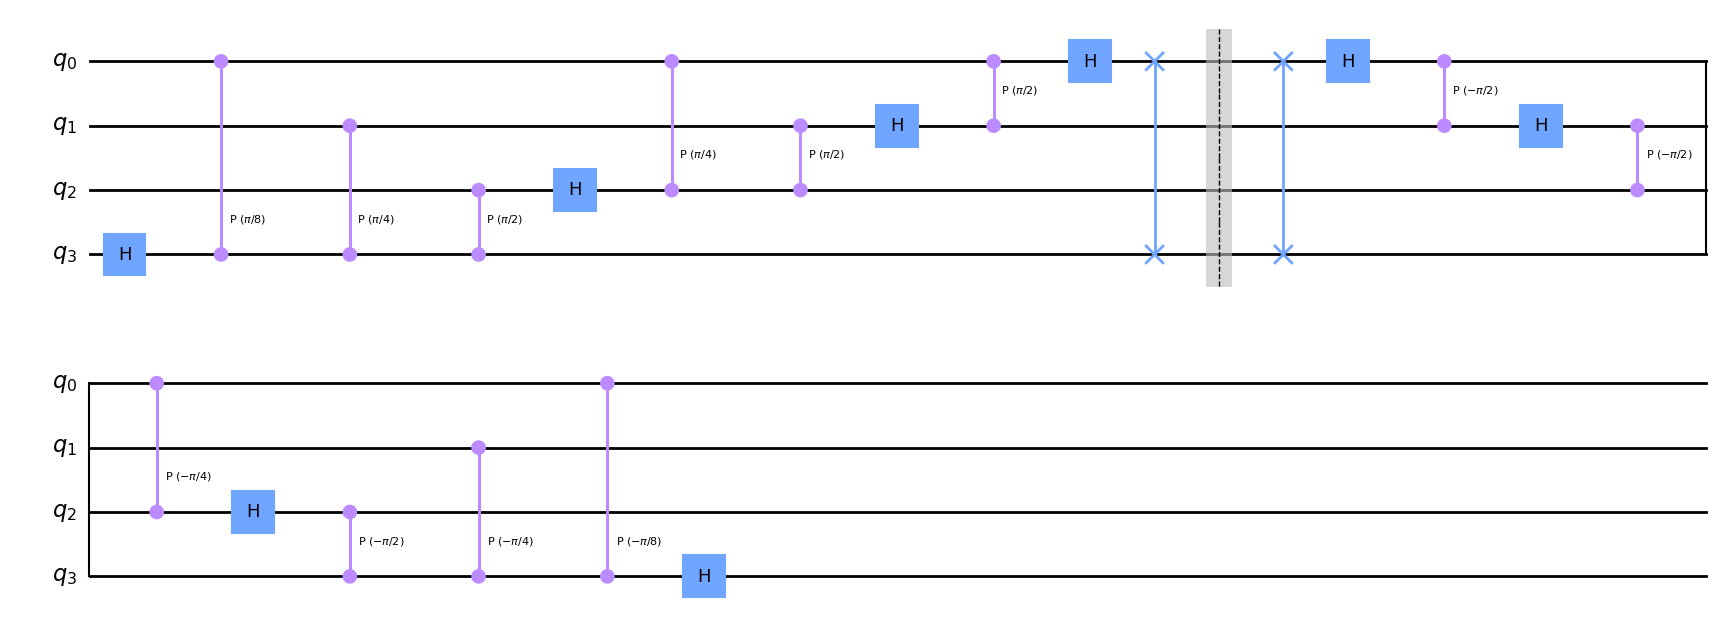

In [7]:
n = 4

iqft = QuantumCircuit(n)


for i in range((n-1), -1, -1):
    iqft.h(i)
    for j in range(i):
        iqft.cp(((np.pi) / (2**(i-j))), j, i)
    
iqft.swap(0, (n-1))  

iqft.barrier()

iqft.swap(0, (n-1))    
for i in range(n):
    for j in range((i-1), -1, -1):
        iqft.cp((-(np.pi) / (2**(i-j))), j, i)
    iqft.h(i)
    


iqft.draw()        
            

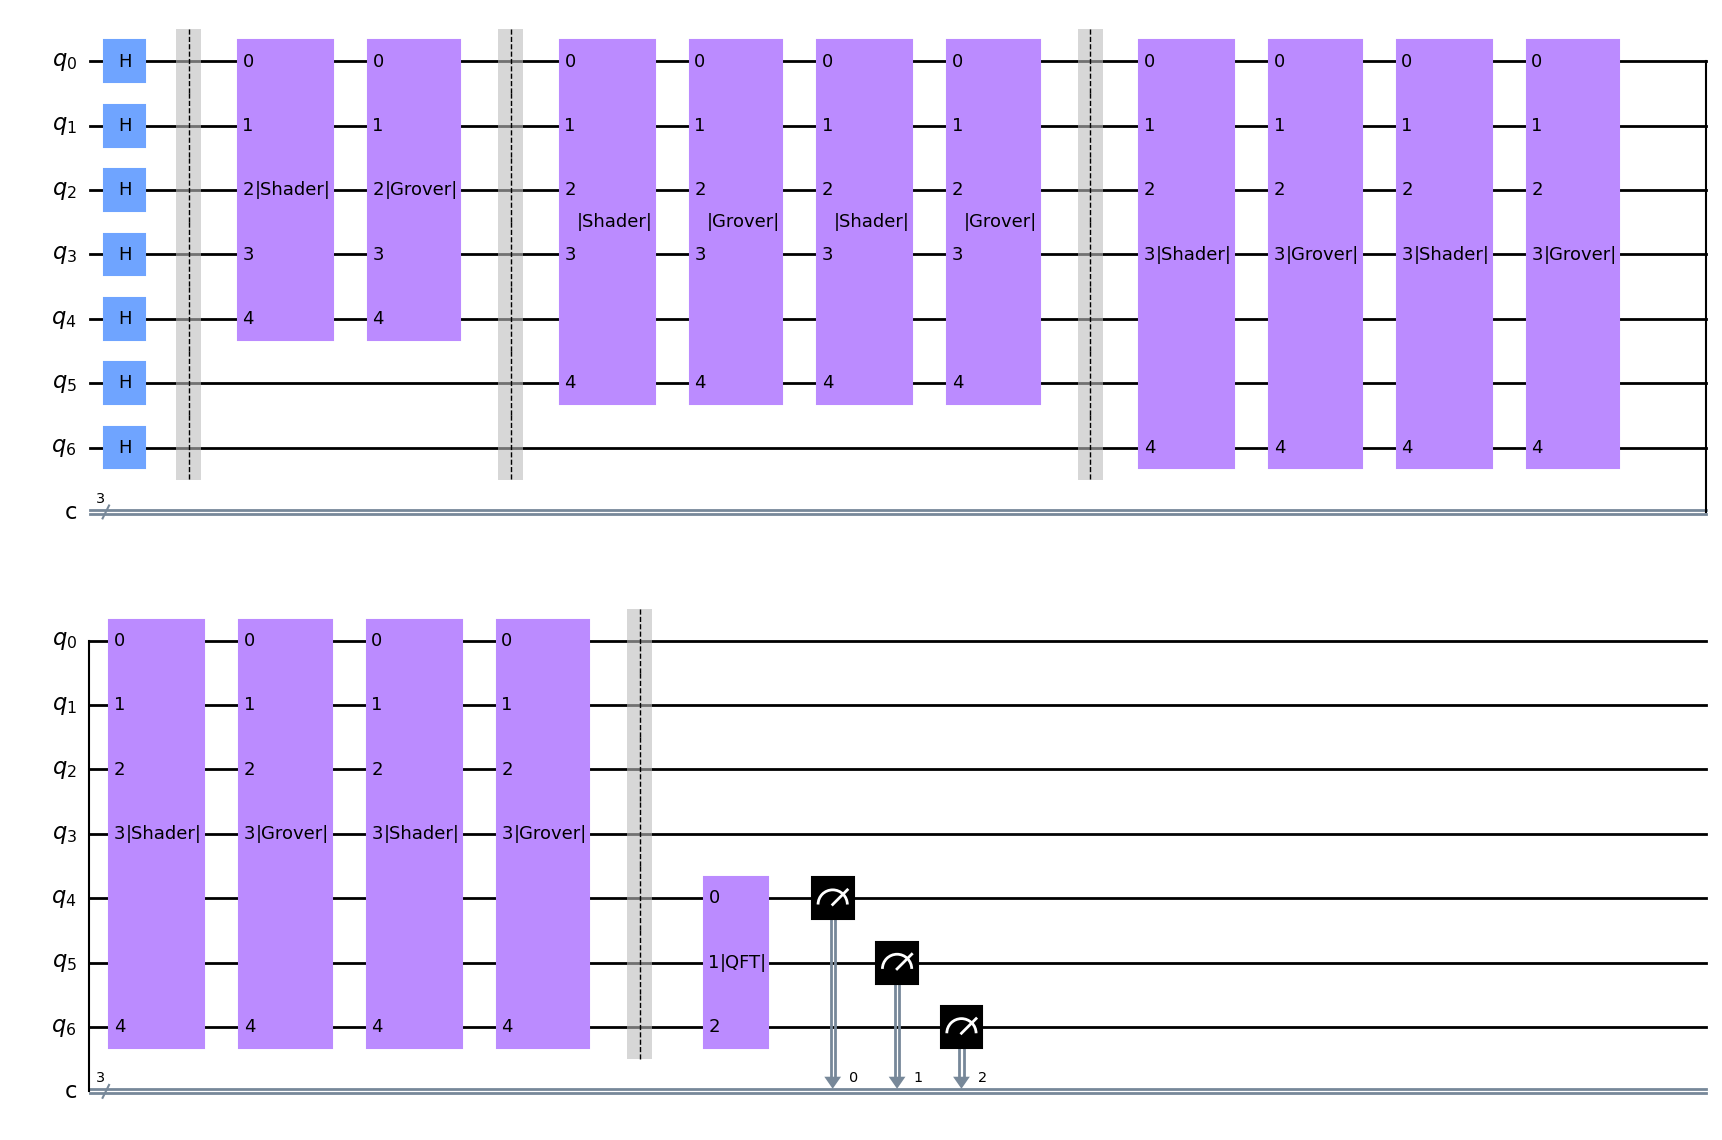

In [8]:
qc = QuantumCircuit(7, 3)

for i in range(7):
    qc.h(i)
    
qc.barrier()

qc.append(shader_counter(), [0,1,2,3,4])
qc.append(grover_counter(), [0,1,2,3,4])

qc.barrier()

for i in range(2):
    qc.append(shader_counter(), [0,1,2,3,5])
    qc.append(grover_counter(), [0,1,2,3,5])
    
qc.barrier()    
    
for i in range(4):
    qc.append(shader_counter(), [0,1,2,3,6])
    qc.append(grover_counter(), [0,1,2,3,6])

qc.barrier()    

qc.append(qft(3), [4,5,6])

qc.measure(4,0)
qc.measure(5,1)
qc.measure(6,2)

qc.draw()

In [ ]:
# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (7) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc)
job_monitor(job, interval=2)

ibmqfactory.load_account:WARNING:2023-10-11 14:10:21,906: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibm_nairobi
Job Status: job is queued (None)

In [35]:
# Running on a simulator:
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(qc, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Circuit circuit-8537 contains invalid instructions {"gates": {|Grover|, |Shader|, |QFT|}} for "statevector" method.


Traceback (most recent call last):
  Input In [35] in <cell line: 5>
    answer = results.get_counts()
  File /opt/conda/lib/python3.8/site-packages/qiskit/result/result.py:269 in get_counts
    exp = self._get_experiment(key)
  File /opt/conda/lib/python3.8/site-packages/qiskit/result/result.py:397 in _get_experiment
    raise QiskitError(result_status, ", ", exp_status)
QiskitError: 'ERROR:  [Experiment 0] Circuit circuit-8537 contains invalid instructions {"gates": {|Grover|, |Shader|, |QFT|}} for "statevector" method. ,  ERROR: Circuit circuit-8537 contains invalid instructions {"gates": {|Grover|, |Shader|, |QFT|}} for "statevector" method.'

Use %tb to get the full traceback.
